In [1]:
# !pip install planarity --user

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import planarity
import networkx as nx
from scipy.cluster import hierarchy
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
stock_features = pd.read_csv(
    'https://sp500-histo.s3.ap-southeast-1.amazonaws.com/stock_features.csv')

In [5]:
stock_features.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,INDUSTRY_SECTOR,INDUSTRY_GROUP,INDUSTRY_SUBGROUP,REL_INDEX,CUR_MKT_CAP,PE_RATIO,PX_TO_BOOK_RATIO,EQY_DVD_YLD_IND,RTG_SP_LT_LC_ISSUER_CREDIT
0,A,A US Equity,61.25,Industrial,Electronics,Electronic Measur Instr,SPX,19678705009,31.65445287,4.495615245,0.862322386,BBB+
1,AA,AA US Equity,36.89,Basic Materials,Mining,Metal-Aluminum,SPX,6794777543,19.7651981,1.13946306,0.977729615,BB-
2,AAL,AAL US Equity,52.31,"Consumer, Cyclical",Airlines,Airlines,SPX,25531095000,10.33535254,7.505798509,0.764233867,BB-
3,AAMC,AAMC US Equity,94.5,Financial,Diversified Finan Serv,Invest Mgmnt/Advis Serv,SPX,146896564.5,NaN,NaN,NaN,NaN
4,AAN,AAN US Equity,39.55,"Consumer, Non-cyclical",Commercial Services,Rental Auto/Equipment,SPX,2794607588,17.74529818,1.862851844,0.278128949,NaN


In [6]:
stock_features['Unnamed: 0'].nunique()

3190

In [7]:
tickers_sectors = stock_features[['Unnamed: 0', 'INDUSTRY_GROUP']]
tickers_sectors.columns = ['ticker', 'industry']
tickers_sectors = tickers_sectors[
    tickers_sectors.industry != '#N/A Invalid Security']

In [8]:
stock_prices = pd.read_csv(
    'https://sp500-histo.s3.ap-southeast-1.amazonaws.com/WIKI_PRICES.csv')

In [9]:
stock_prices.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,31.105117,34.181447,27.345157,30.079673,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,29.355027,29.396044,27.215268,27.604936,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,28.240711,30.079673,27.386175,30.079673,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,29.054230,29.826730,27.516065,27.516065,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,27.434029,28.671398,27.345157,28.069804,3464400.0


In [10]:
df_prices = pd.pivot(stock_prices[['ticker', 'date', 'adj_close']],
                     index='date', columns='ticker', values='adj_close')
del stock_prices

recent_returns = df_prices.pct_change().iloc[-2000:]

In [11]:
recent_returns

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2009-10-09,0.002555,NaN,0.022883,NaN,0.018571,NaN,0.014100,0.002345,0.006340,NaN,...,-0.031690,-0.004739,0.012308,NaN,0.007308,NaN,NaN,-0.010989,NaN,-0.023213
2009-10-12,-0.000364,NaN,0.008949,NaN,-0.013090,NaN,0.000535,-0.005459,0.001785,NaN,...,0.032727,0.009524,0.033435,NaN,0.002100,NaN,NaN,0.018519,NaN,-0.022514
2009-10-13,-0.006191,NaN,-0.015521,NaN,0.000000,NaN,-0.019776,-0.003136,-0.004140,NaN,...,0.017606,0.000000,0.027941,NaN,-0.004953,NaN,NaN,0.014545,NaN,0.015355
2009-10-14,0.010993,NaN,0.009009,NaN,0.000000,NaN,0.023991,0.027792,0.006684,NaN,...,0.245675,0.051887,0.097282,NaN,-0.003638,NaN,NaN,0.007168,NaN,-0.036547
2009-10-15,0.001087,NaN,0.008929,NaN,0.000000,NaN,0.001065,0.004337,-0.003816,NaN,...,-0.005556,0.017937,-0.002608,NaN,0.001922,NaN,NaN,0.017794,NaN,-0.006540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-13,0.007575,0.040751,0.000186,0.011482,0.008179,0.074339,-0.001332,0.022588,0.013929,0.002310,...,0.020548,-0.013841,0.000000,0.0,0.000000,-0.021978,0.017376,0.000000,0.007832,0.037037
2017-07-14,0.005393,0.008609,0.007619,0.005405,-0.012039,0.078934,0.000000,-0.011432,0.008594,0.014341,...,-0.011745,0.007018,0.000000,0.0,0.000000,0.025281,-0.004270,0.000000,0.004758,-0.011905
2017-07-17,0.000488,0.002203,-0.006455,-0.008066,0.010331,-0.000238,0.004000,-0.002940,0.003489,0.007069,...,-0.005093,0.001742,0.000000,0.0,0.000000,-0.019178,0.012864,0.000000,-0.004420,0.000000


In [12]:
selected_columns = []
for col in tqdm(df_prices.columns):
    if len(recent_returns[col].dropna()) > 0.98 * len(recent_returns[col]):
        selected_columns.append(col)

100%|████████████████████████████████████████████████████████████████████████████| 3190/3190 [00:00<00:00, 7569.36it/s]


In [13]:
len(selected_columns)

2589

In [14]:
df_returns = recent_returns[selected_columns].fillna(0)

In [15]:
stacked_returns = df_returns.stack().reset_index()
stacked_returns.columns = ['date', 'ticker', 'return']

In [16]:
df_returns.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,ZEUS,ZIGO,ZINC,ZION,ZIOP,ZIXI,ZLC,ZMH,ZQK,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2009-10-09,0.002555,0.022883,0.018571,0.014100,0.002345,0.006340,0.009763,-0.021426,0.009375,0.023358,...,0.002362,-0.012113,-0.014026,0.007585,-0.031690,-0.004739,0.012308,0.007308,-0.010989,-0.023213
2009-10-12,-0.000364,0.008949,-0.013090,0.000535,-0.005459,0.001785,0.004981,-0.033975,0.005750,-0.008559,...,-0.030640,0.055858,-0.016736,-0.015634,0.032727,0.009524,0.033435,0.002100,0.018519,-0.022514
2009-10-13,-0.006191,-0.015521,0.000000,-0.019776,-0.003136,-0.004140,0.020408,-0.053146,-0.005277,-0.035971,...,0.014936,-0.036129,0.019574,0.060000,0.017606,0.000000,0.027941,-0.004953,0.014545,0.015355
2009-10-14,0.010993,0.009009,0.000000,0.023991,0.027792,0.006684,0.053143,0.021048,0.019894,0.041791,...,0.022245,0.046854,0.036728,0.034961,0.245675,0.051887,0.097282,-0.003638,0.007168,-0.036547
2009-10-15,0.001087,0.008929,0.000000,0.001065,0.004337,-0.003816,0.001356,-0.005255,0.012137,-0.047278,...,0.025778,-0.042199,-0.000805,0.009115,-0.005556,0.017937,-0.002608,0.001922,0.017794,-0.006540


In [17]:
stacked_returns.head()

,date,ticker,return
0,2009-10-09,A,0.002555
1,2009-10-09,AAL,0.022883
2,2009-10-09,AAN,0.018571
3,2009-10-09,AAON,0.014100
4,2009-10-09,AAP,0.002345


In [18]:
ticker_sector_returns = pd.merge(tickers_sectors, stacked_returns, on=['ticker'])

In [19]:
ticker_sector_returns.head()

,ticker,industry,date,return
0,A,Electronics,2009-10-09,0.002555
1,A,Electronics,2009-10-12,-0.000364
2,A,Electronics,2009-10-13,-0.006191
3,A,Electronics,2009-10-14,0.010993
4,A,Electronics,2009-10-15,0.001087


In [20]:
mean_return_stocks = (ticker_sector_returns
                        .groupby(['ticker', 'date'])['return']
                        .mean()
                        .clip(lower=-0.25, upper=0.25)
                        .reset_index())

In [21]:
mean_return_stocks.head()

,ticker,date,return
0,A,2009-10-09,0.002555
1,A,2009-10-12,-0.000364
2,A,2009-10-13,-0.006191
3,A,2009-10-14,0.010993
4,A,2009-10-15,0.001087


In [22]:
df_stock_returns = pd.pivot(mean_return_stocks,
                               index='date',
                               columns='ticker',
                               values='return')

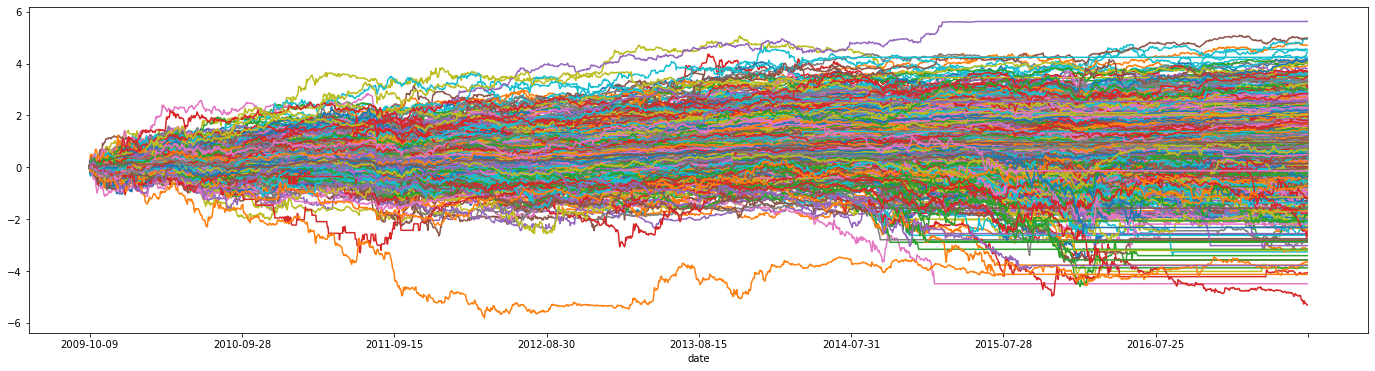

In [23]:
df_stock_returns.cumsum().plot(figsize=(24, 6), legend=False);

In [24]:
df_stock_returns.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,ZEUS,ZIGO,ZINC,ZION,ZIOP,ZIXI,ZLC,ZMH,ZQK,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2009-10-09,0.002555,0.022883,0.018571,0.014100,0.002345,0.006340,0.009763,-0.021426,0.009375,0.023358,...,0.002362,-0.012113,-0.014026,0.007585,-0.031690,-0.004739,0.012308,0.007308,-0.010989,-0.023213
2009-10-12,-0.000364,0.008949,-0.013090,0.000535,-0.005459,0.001785,0.004981,-0.033975,0.005750,-0.008559,...,-0.030640,0.055858,-0.016736,-0.015634,0.032727,0.009524,0.033435,0.002100,0.018519,-0.022514
2009-10-13,-0.006191,-0.015521,0.000000,-0.019776,-0.003136,-0.004140,0.020408,-0.053146,-0.005277,-0.035971,...,0.014936,-0.036129,0.019574,0.060000,0.017606,0.000000,0.027941,-0.004953,0.014545,0.015355
2009-10-14,0.010993,0.009009,0.000000,0.023991,0.027792,0.006684,0.053143,0.021048,0.019894,0.041791,...,0.022245,0.046854,0.036728,0.034961,0.245675,0.051887,0.097282,-0.003638,0.007168,-0.036547
2009-10-15,0.001087,0.008929,0.000000,0.001065,0.004337,-0.003816,0.001356,-0.005255,0.012137,-0.047278,...,0.025778,-0.042199,-0.000805,0.009115,-0.005556,0.017937,-0.002608,0.001922,0.017794,-0.006540


In [25]:
df_stock_returns.corr()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,ZEUS,ZIGO,ZINC,ZION,ZIOP,ZIXI,ZLC,ZMH,ZQK,ZUMZ
ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.358233,0.360792,0.487269,0.301888,0.396546,0.467236,0.369371,0.430922,0.413257,...,0.398318,0.382976,0.363077,0.530989,0.291794,0.367780,0.265232,0.493954,0.309966,0.295291
AAL,0.358233,1.000000,0.241707,0.283977,0.228677,0.240522,0.325800,0.224144,0.240917,0.277873,...,0.221213,0.220076,0.206718,0.353446,0.176660,0.235753,0.149744,0.248169,0.230766,0.200726
AAN,0.360792,0.241707,1.000000,0.317375,0.253161,0.243514,0.284732,0.270647,0.226719,0.236555,...,0.298630,0.254798,0.232057,0.322844,0.190334,0.255324,0.182743,0.247134,0.157877,0.271111
AAON,0.487269,0.283977,0.317375,1.000000,0.251140,0.292750,0.431206,0.333226,0.312602,0.471065,...,0.421163,0.392181,0.352055,0.463932,0.254407,0.348144,0.236400,0.375981,0.321893,0.330698
AAP,0.301888,0.228677,0.253161,0.251140,1.000000,0.200552,0.198480,0.158311,0.227752,0.264510,...,0.193844,0.168301,0.175843,0.296308,0.147575,0.181710,0.141100,0.227828,0.171654,0.263791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIXI,0.367780,0.235753,0.255324,0.348144,0.181710,0.245629,0.289900,0.276552,0.246830,0.356062,...,0.302321,0.391401,0.256185,0.336017,0.217664,1.000000,0.231042,0.284291,0.247838,0.245293
ZLC,0.265232,0.149744,0.182743,0.236400,0.141100,0.182931,0.186837,0.168042,0.167398,0.195293,...,0.215445,0.212920,0.220315,0.244444,0.134397,0.231042,1.000000,0.214886,0.189383,0.172854
ZMH,0.493954,0.248169,0.247134,0.375981,0.227828,0.314807,0.317175,0.292800,0.334784,0.321719,...,0.273003,0.337952,0.278376,0.384940,0.165118,0.284291,0.214886,1.000000,0.254508,0.207239


In [26]:
# sorted by hierarchical clustering
corr_returns = df_stock_returns.corr()

dist = 1 - corr_returns.values
dim = len(dist)
tri_a, tri_b = np.triu_indices(dim, k=1)
Z = hierarchy.linkage(dist[tri_a, tri_b], method='ward')
permutation = hierarchy.leaves_list(
    hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))

HC_tickers = df_stock_returns.columns[permutation]
HC_corr = corr_returns.values[permutation, :][:, permutation]
corr = pd.DataFrame(HC_corr, columns=HC_tickers, index=HC_tickers)

# plt.figure(figsize=(14, 12))
# plt.pcolormesh(corr)
# plt.colorbar()
# plt.title('Correlation matrix sorted using hierarchical clustering seriation')
# plt.xticks(ticks=range(len(corr)),
#            labels=corr.columns,
#            rotation=90)
# plt.yticks(ticks=range(len(corr)),
#            labels=corr.columns)
# plt.show()

In [27]:
complete_graph = nx.Graph()
for i in range(len(corr)):
    for j in range(i+1, len(corr)):
        complete_graph.add_edge(corr.columns[i],
                                corr.columns[j],
                                weight=1 - corr.values[i, j])

In [28]:
def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True),
                                     key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges


def compute_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG

In [29]:
sorted_edges = sort_graph_edges(complete_graph)
PMFG = compute_PMFG(sorted_edges, len(complete_graph.nodes))

In [30]:
edges = list(PMFG.edges)

list_edges = []
for edge in edges:
  list_edges.append((edge[0],
                     edge[1],
                     corr.loc[edge[0]][edge[1]]))
edges = pd.DataFrame(list_edges)
edges.columns = ['source', 'target', 'weight']

In [31]:
edges

,source,target,weight
0,FOX,FOXA,0.974855
1,FOX,DIS,0.650796
2,FOX,CBS,0.649522
3,FOX,VIAB,0.598263
4,FOX,HON,0.590777
...,...,...,...
7723,DOOR,OHRP,0.082814
7724,DOOR,ARCW,0.061059
7725,PTGI,TAM,0.127057
7726,ITIC,CFFI,0.124546


In [39]:
edges_non_neg = edges[edges['weight'] >= 0]

### Applying node2vec

In [40]:
G = StellarGraph(edges=edges_non_neg)

In [41]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2578, Edges: 7727

 Node types:
  default: [2578]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [7727]
        Weights: range=[0.0115521, 0.974855], mean=0.49898, std=0.166817
        Features: none


In [42]:
rw = BiasedRandomWalk(G)

In [43]:
weighted_walks = rw.run(
    nodes=G.nodes(),
    length=100,
    n=50,
    p=0.5,
    q=2.0,
    weighted=True,
    seed=42)

print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 128900


In [46]:
weighted_model = Word2Vec(
    weighted_walks, window=5, min_count=0, sg=1, workers=1
)

In [48]:
emb = weighted_model.wv["FOX"]
emb.shape

(100,)

In [50]:
node_ids = weighted_model.wv.index_to_key
weighted_node_embeddings = (
    weighted_model.wv.vectors
)

tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

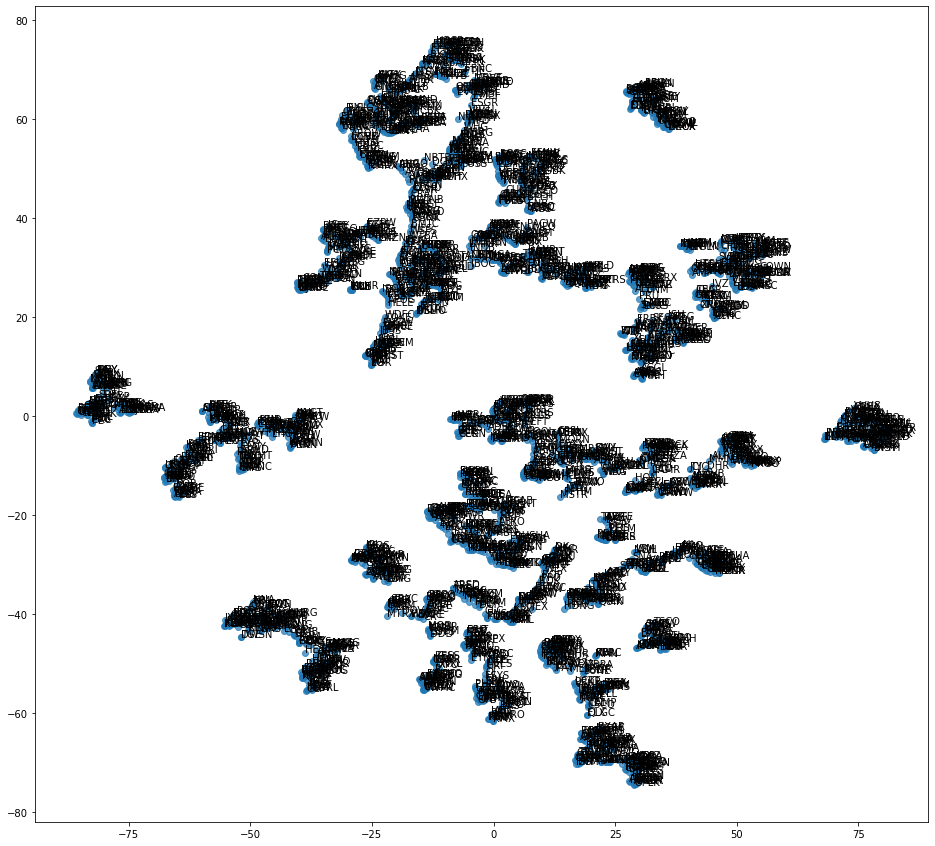

In [51]:
fig, ax = plt.subplots(figsize=(16, 15))
ax.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    cmap="jet",
    alpha=0.7)

for i, industry in enumerate(node_ids):
    ax.annotate(industry,
                (weighted_node_embeddings_2d[i, 0],
                 weighted_node_embeddings_2d[i, 1]))

### Visualizing in tensorbaord

In [60]:
weighted_model.save('weighted_model')

In [66]:
import gensim

In [85]:
model = gensim.models.word2vec.Word2Vec.load('weighted_model')

with open( 'embeddings.tsv', 'w+') as tensors:
    with open( 'metadata.tsv', 'w+') as metadata:
         for word in model.wv.index_to_key:
                encoded=word.encode()
#                 print(encoded)
                metadata.write(word + '\n')
                vector_row = '\t'.join(map(str, model.wv[word]))
                tensors.write(vector_row + '\n')